In [1]:
import os
import sys

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..', '..')))
print(sys.path)

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from source.null_imputers.missforest_imputer import MissForestImputer
from source.error_injectors.nulls_injector import NullsInjector
from source.null_imputers.boostclean_wrapper import BoostCleanWrapper
from source.utils.pipeline_utils import encode_dataset_for_missforest, decode_dataset_for_missforest

from virny.datasets import ACSIncomeDataset, LawSchoolDataset, GermanCreditDataset, DiabetesDataset2019, CardiovascularDiseaseDataset, BankMarketingDataset

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.datasets import make_blobs
import umap

from clusteval import clusteval

['c:\\Users\\nazar\\anaconda3\\envs\\stability\\python39.zip', 'c:\\Users\\nazar\\anaconda3\\envs\\stability\\DLLs', 'c:\\Users\\nazar\\anaconda3\\envs\\stability\\lib', 'c:\\Users\\nazar\\anaconda3\\envs\\stability', '', 'c:\\Users\\nazar\\anaconda3\\envs\\stability\\lib\\site-packages', 'c:\\Users\\nazar\\anaconda3\\envs\\stability\\lib\\site-packages\\win32', 'c:\\Users\\nazar\\anaconda3\\envs\\stability\\lib\\site-packages\\win32\\lib', 'c:\\Users\\nazar\\anaconda3\\envs\\stability\\lib\\site-packages\\Pythonwin', 'c:\\RAI\\data-cleaning-stability']


c:\Users\nazar\anaconda3\envs\stability\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def get_dataset(dataset_name, seed=42):
    if dataset_name == 'acsincome':
        data_loader = ACSIncomeDataset(state=['GA'], year=2018, with_nulls=False,
                                subsample_size=5000, subsample_seed=seed)
    elif dataset_name == 'lawschool':
        data_loader = LawSchoolDataset()
    elif dataset_name == 'germancredit':
        data_loader = GermanCreditDataset()
    elif dataset_name == 'diabetes':
        data_loader = DiabetesDataset2019()
    elif dataset_name == 'cardiovascular':
        data_loader = CardiovascularDiseaseDataset()
    elif dataset_name == 'bankmarketing':
        data_loader = BankMarketingDataset()
    else:
        raise ValueError(f"Unknown dataset name: {dataset_name}")
    
    X_train_val, X_test, y_train_val, y_test = train_test_split(data_loader.X_data, data_loader.y_data,
                                                                test_size=0.2,
                                                                random_state=seed)
    
    X_train_encoded, cat_encoders, categorical_columns_idxs = encode_dataset_for_missforest(X_train_val.dropna())
    return X_train_encoded, cat_encoders, categorical_columns_idxs

In [6]:
def silhoeutte_score_experiment(X_train_encoded, normalize=False, min_clusters=2, max_clusters=10):
    # Set parameters, as an example dbscan
    ce = clusteval(cluster="kmeans", normalize=normalize, min_clust=min_clusters, max_clust=max_clusters)
    # Fit to find optimal number of clusters using dbscan
    results= ce.fit(X_train_encoded)
    print(results['score'])
    ce.plot(figsize=(8, 6))
    cluster_labels = results['labx']
    score_df = results['score']
    best_n_clusters = score_df.sort_values(by='score', ascending=False)['clusters'].iloc[0]
    
    return best_n_clusters, cluster_labels

In [8]:
def dimesionality_reduction_visualization(X_train_encoded, cluster_labels, seed=42):
    # PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_train_encoded)
    
    # t-SNE
    tsne = TSNE(n_components=2, random_state=seed)
    X_tsne = tsne.fit_transform(X_train_encoded)
    
    # UMAP
    umap_model = umap.UMAP(n_neighbors=5, min_dist=0.3)
    X_umap = umap_model.fit_transform(X_train_encoded)
    
    # Plot 3 visualizations in 1 row
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=cluster_labels, ax=axs[0])
    axs[0].set_title('PCA')
    sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=cluster_labels, ax=axs[1])
    axs[1].set_title('t-SNE')
    sns.scatterplot(x=X_umap[:, 0], y=X_umap[:, 1], hue=cluster_labels, ax=axs[2])
    axs[2].set_title('UMAP')
    plt.show()

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[kmeans], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.


[clusteval] >INFO:   0%|          | 0/8 [00:00<?, ?it/s]c:\Users\nazar\anaconda3\envs\stability\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
[clusteval] >INFO:  12%|█▎        | 1/8 [00:00<00:04,  1.63it/s]c:\Users\nazar\anaconda3\envs\stability\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
[clusteval] >INFO:  25%|██▌       | 2/8 [00:01<00:03,  1.84it/s]c:\Users\nazar\anaconda3\envs\stability\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
[clusteval] >INFO:  38%|███▊      | 3/8 [00:01<00:02,  1.99it/s

   cluster_threshold  clusters     score
0                  2         2  0.381007
1                  3         3  0.476788
2                  4         4  0.525685
3                  5         5  0.567200
4                  6         6  0.629416
5                  7         7  0.670159
6                  8         8  0.610300
7                  9         9  0.549179


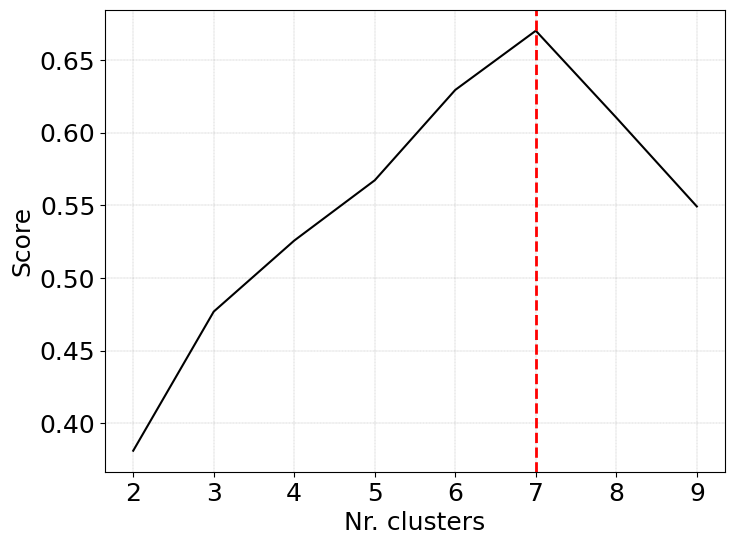

c:\Users\nazar\anaconda3\envs\stability\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


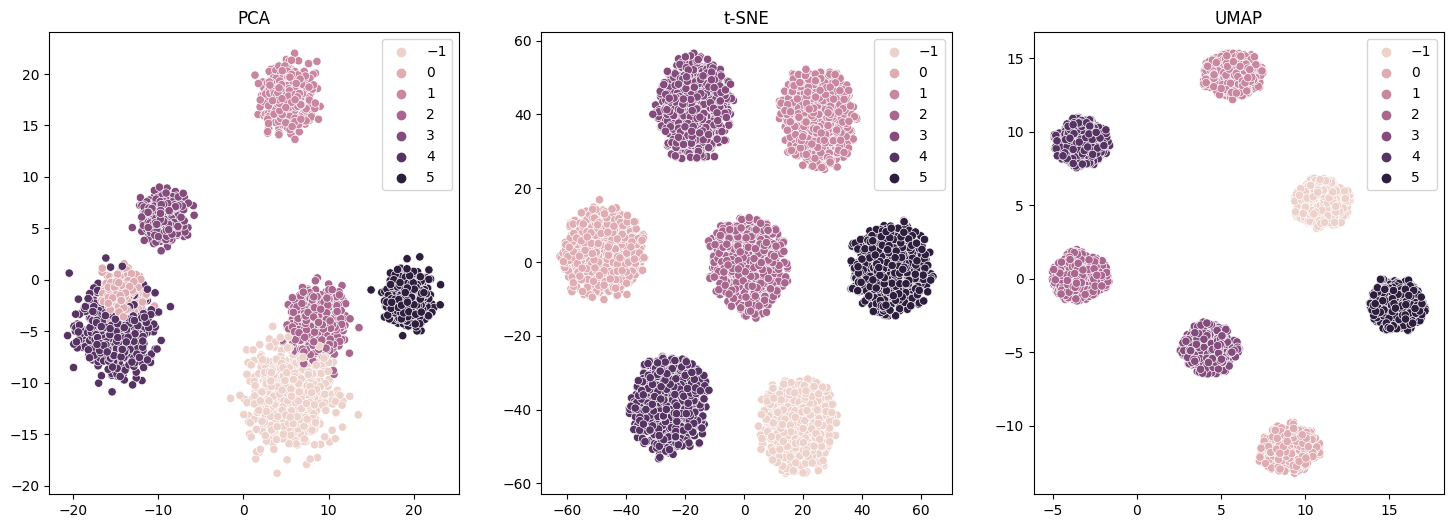

In [7]:
test_X, test_y = make_blobs(n_samples=5000, centers=7, n_features=10, random_state=42, cluster_std=[1.0, 2.0, 1.5, 1.2, 2.3, 1.4, 1.1])
best_n_clusters, cluster_labels = silhoeutte_score_experiment(test_X)
dimesionality_reduction_visualization(test_X, cluster_labels)

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[kmeans], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO:   0%|          | 0/1 [00:00<?, ?it/s]c:\Users\nazar\anaconda3\envs\stability\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
[clusteval] >INFO: 100%|██████████| 1/1 [00:32<00:00, 32.10s/it]
[clusteval] >INFO> Optimal number clusters detected: [6].
[clusteval] >INFO> Fin.


   cluster_threshold  clusters    score
0                  6         6  0.96289


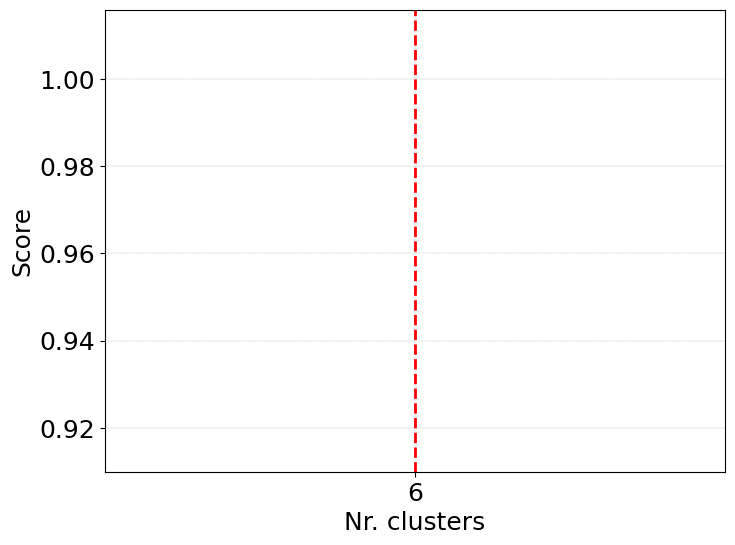

c:\Users\nazar\anaconda3\envs\stability\lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


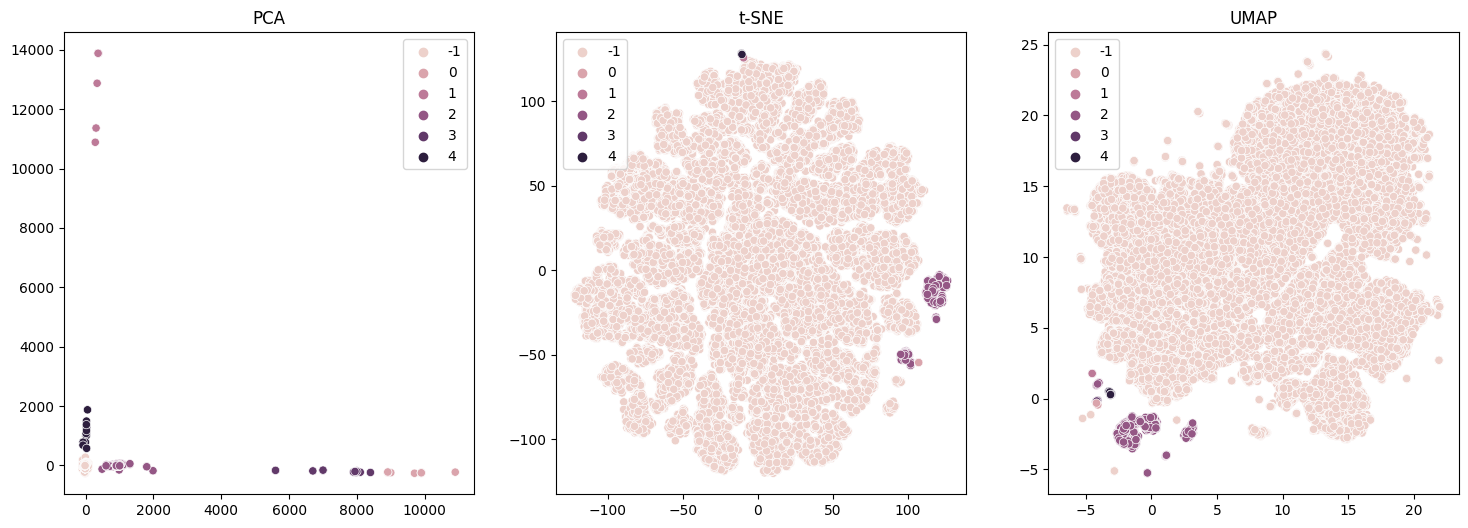

In [9]:
X_train_encoded_law, cat_encoders_law, categorical_columns_idxs_law = get_dataset('cardiovascular')
best_n_clusters_law, cluster_labels_law = silhoeutte_score_experiment(X_train_encoded_law, min_clusters=6, max_clusters=7)
dimesionality_reduction_visualization(X_train_encoded_law, cluster_labels_law)

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[kmeans], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO:   0%|          | 0/8 [00:00<?, ?it/s]c:\Users\nazar\anaconda3\envs\stability\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
[clusteval] >INFO:  12%|█▎        | 1/8 [00:34<03:59, 34.28s/it]c:\Users\nazar\anaconda3\envs\stability\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
[clusteval] >INFO:  25%|██▌       | 2/8 [01:07<03:23, 33.85s/it]c:\Users\nazar\anaconda3\envs\stability\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change

   cluster_threshold  clusters     score
0                  2         2  0.992339
1                  3         3  0.992625
2                  4         4  0.962365
3                  5         5  0.962969
4                  6         6  0.962890
5                  7         7  0.344900
6                  8         8  0.345811
7                  9         9  0.345123


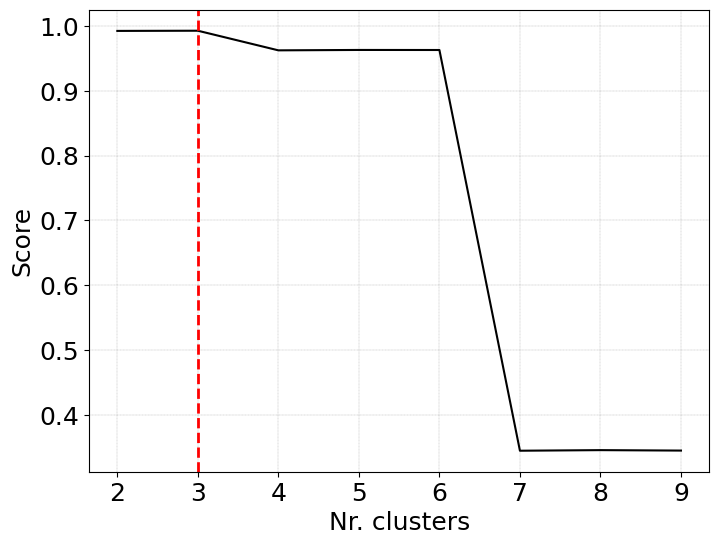

c:\Users\nazar\anaconda3\envs\stability\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\nazar\anaconda3\envs\stability\lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


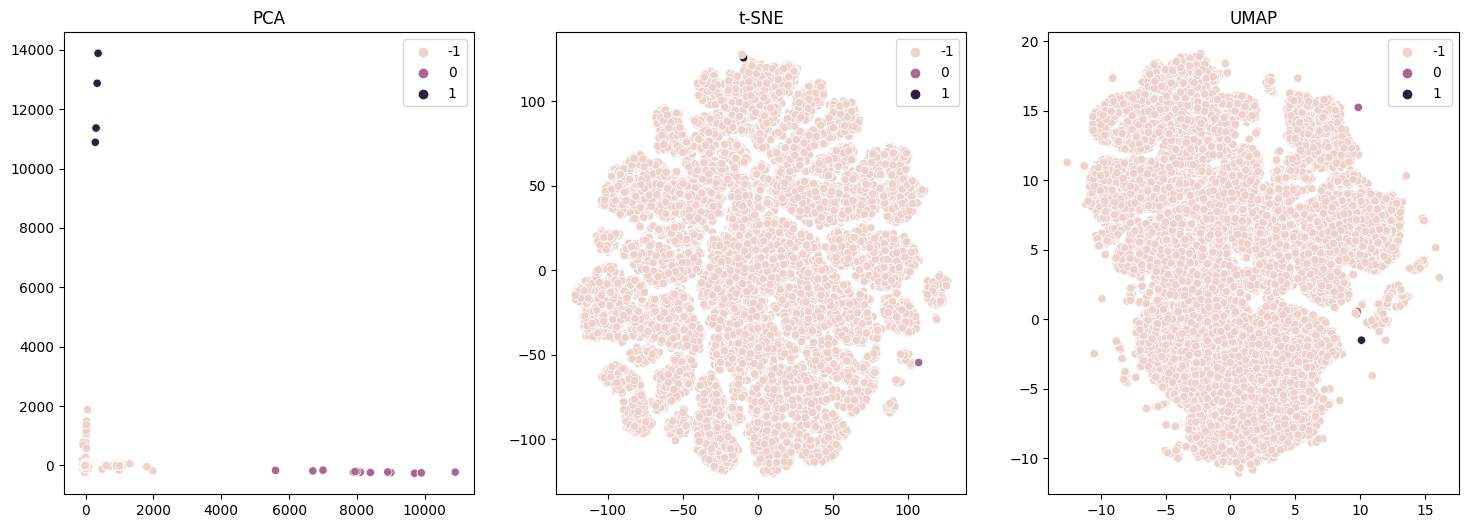

In [8]:
X_train_encoded_law, cat_encoders_law, categorical_columns_idxs_law = get_dataset('cardiovascular')
best_n_clusters_law, cluster_labels_law = silhoeutte_score_experiment(X_train_encoded_law)
dimesionality_reduction_visualization(X_train_encoded_law, cluster_labels_law)

In [13]:
X_train_encoded_law.shape

(30556, 13)

c:\Users\nazar\anaconda3\envs\stability\lib\site-packages\virny\datasets\finance.py:106: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'unknown' in df[col].unique():
[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[kmeans], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO:   0%|          | 0/8 [00:00<?, ?it/s]c:\Users\nazar\anaconda3\envs\stability\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
[clusteval] >INFO:  12%|█▎        | 1/8 [00:10<01:11, 10.21s/it]c:\Users\nazar\anaconda3\envs\stability\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly 

   cluster_threshold  clusters     score
0                  2         2  0.846678
1                  3         3  0.780742
2                  4         4  0.751867
3                  5         5  0.711682
4                  6         6  0.665994
5                  7         7  0.627748
6                  8         8  0.629357
7                  9         9  0.598901


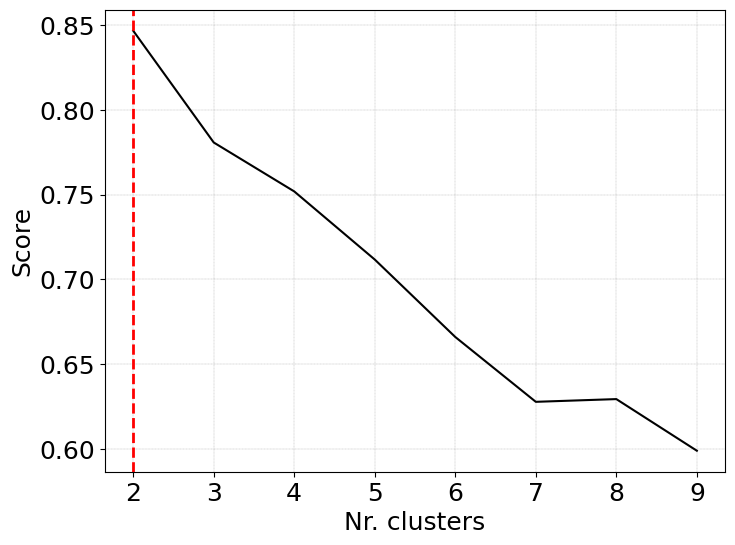

c:\Users\nazar\anaconda3\envs\stability\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\nazar\anaconda3\envs\stability\lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


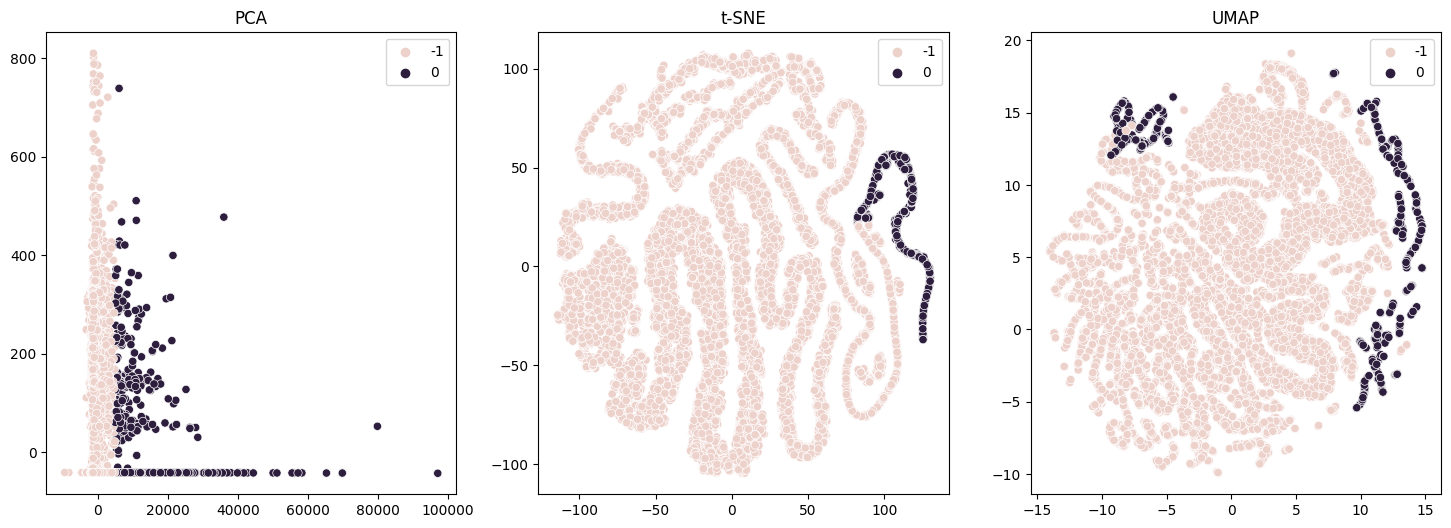

In [5]:
X_train_encoded_law, cat_encoders_law, categorical_columns_idxs_law = get_dataset('bankmarketing')
best_n_clusters_law, cluster_labels_law = silhoeutte_score_experiment(X_train_encoded_law)
dimesionality_reduction_visualization(X_train_encoded_law, cluster_labels_law)

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[kmeans], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO:   0%|          | 0/8 [00:00<?, ?it/s]c:\Users\nazar\anaconda3\envs\stability\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
[clusteval] >INFO:  12%|█▎        | 1/8 [00:03<00:23,  3.29s/it]c:\Users\nazar\anaconda3\envs\stability\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
[clusteval] >INFO:  25%|██▌       | 2/8 [00:06<00:18,  3.03s/it]c:\Users\nazar\anaconda3\envs\stability\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change

   cluster_threshold  clusters     score
0                  2         2  0.336802
1                  3         3  0.300759
2                  4         4  0.314618
3                  5         5  0.289569
4                  6         6  0.270914
5                  7         7  0.263274
6                  8         8  0.248870
7                  9         9  0.253341


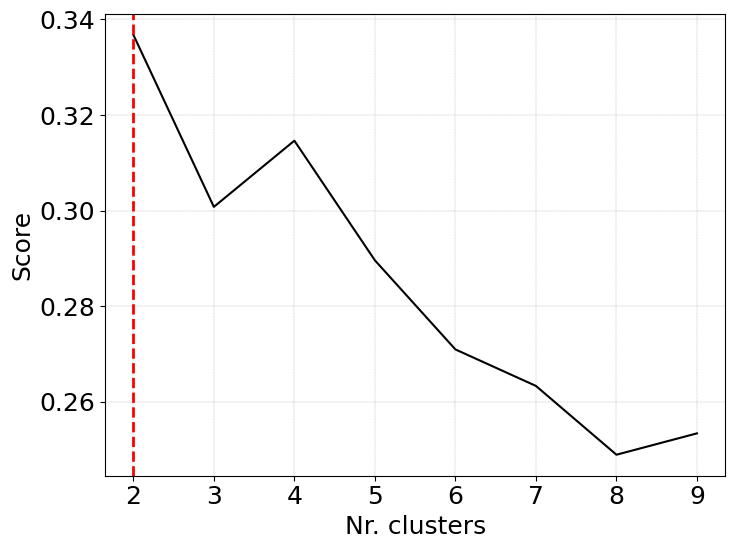

c:\Users\nazar\anaconda3\envs\stability\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


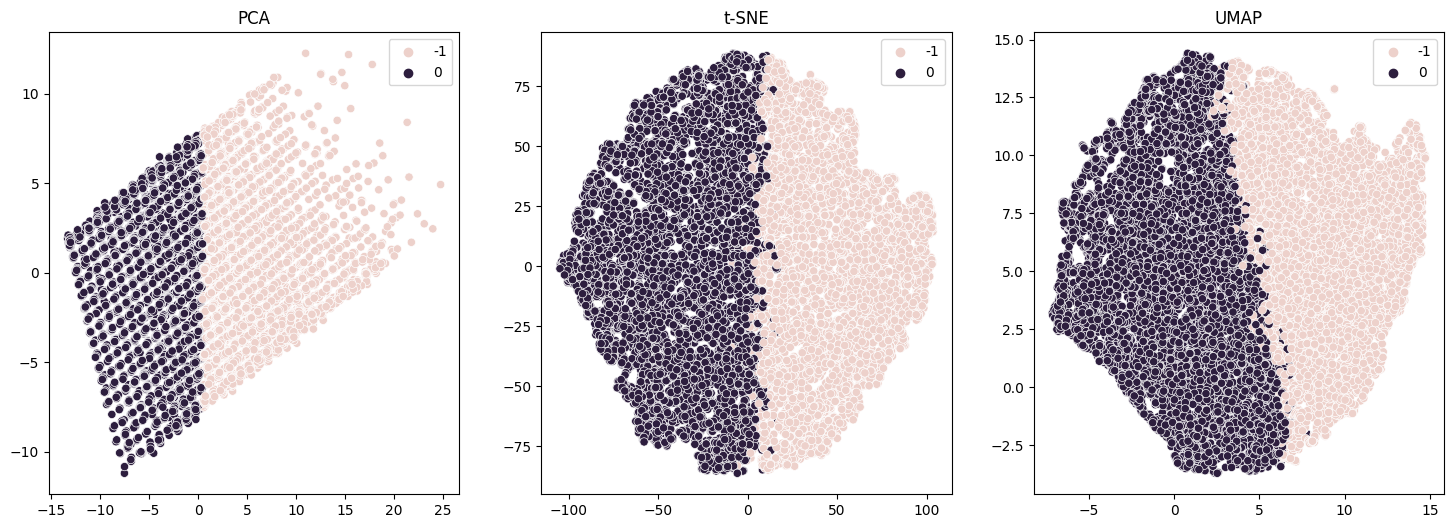

In [50]:
# get dataset LawSchool
X_train_encoded_law, cat_encoders_law, categorical_columns_idxs_law = get_dataset('lawschool')
best_n_clusters_law, cluster_labels_law = silhoeutte_score_experiment(X_train_encoded_law)
dimesionality_reduction_visualization(X_train_encoded_law, cluster_labels_law)

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[kmeans], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO:   0%|          | 0/8 [00:00<?, ?it/s]c:\Users\nazar\anaconda3\envs\stability\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\nazar\anaconda3\envs\stability\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
[clusteval] >INFO:  25%|██▌       | 2/8 [00:00<00:00, 10.47it/s]c:\Users\nazar\anaconda3\envs\stability\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly 

   cluster_threshold  clusters     score
0                  2         2  0.721107
1                  3         3  0.649702
2                  4         4  0.614328
3                  5         5  0.577965
4                  6         6  0.579351
5                  7         7  0.580179
6                  8         8  0.581922
7                  9         9  0.584644


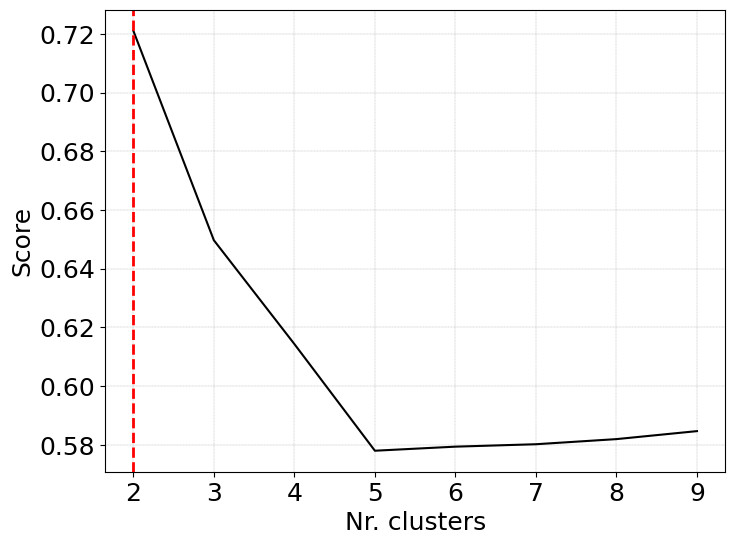

c:\Users\nazar\anaconda3\envs\stability\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\nazar\anaconda3\envs\stability\lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


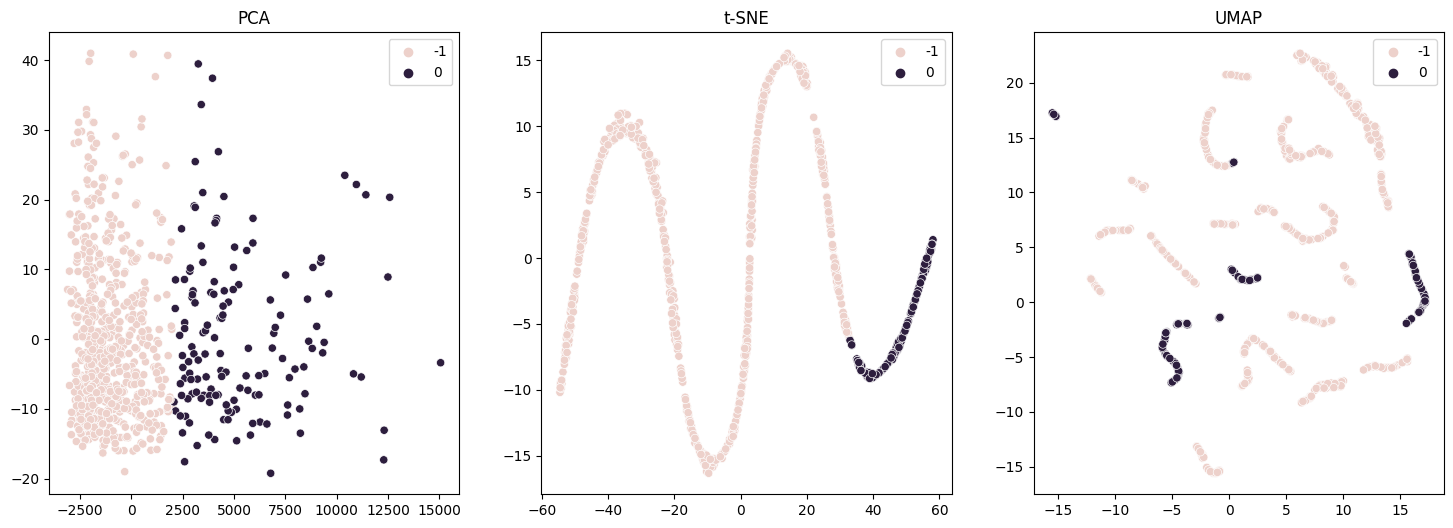

In [51]:
# get dataset GermanCredit
X_train_encoded_credit, cat_encoders_credit, categorical_columns_idxs_credit = get_dataset('germancredit')
best_n_clusters_credit, cluster_labels_credit = silhoeutte_score_experiment(X_train_encoded_credit)
dimesionality_reduction_visualization(X_train_encoded_credit, cluster_labels_credit)

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[kmeans], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO:   0%|          | 0/8 [00:00<?, ?it/s]c:\Users\nazar\anaconda3\envs\stability\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
c:\Users\nazar\anaconda3\envs\stability\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
[clusteval] >INFO:  25%|██▌       | 2/8 [00:00<00:00, 13.03it/s]c:\Users\nazar\anaconda3\envs\stability\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly 

   cluster_threshold  clusters     score
0                  2         2  0.401862
1                  3         3  0.287916
2                  4         4  0.222548
3                  5         5  0.204579
4                  6         6  0.186833
5                  7         7  0.180398
6                  8         8  0.171991
7                  9         9  0.162275


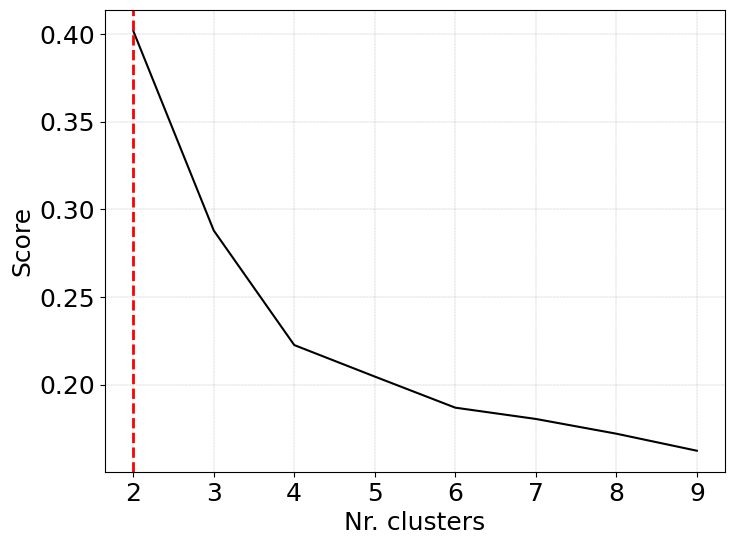

c:\Users\nazar\anaconda3\envs\stability\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\nazar\anaconda3\envs\stability\lib\site-packages\umap\spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


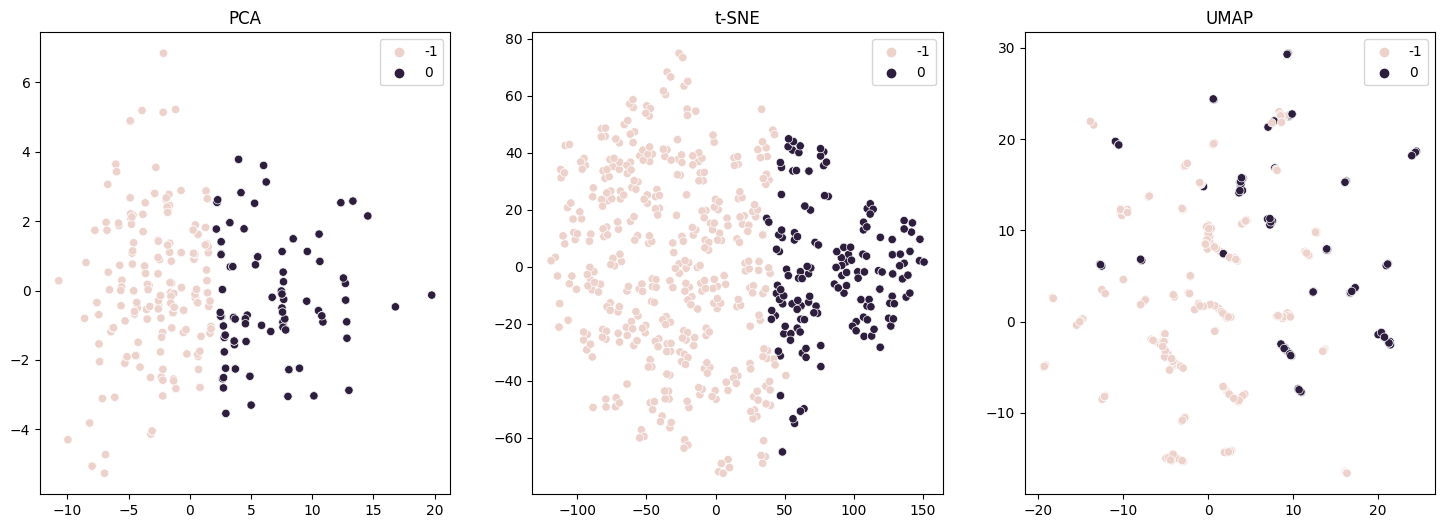

In [52]:
# get dataset Diabetes
X_train_encoded_diabetes, cat_encoders_diabetes, categorical_columns_idxs_diabetes = get_dataset('diabetes')
best_n_clusters_diabetes, cluster_labels_diabetes = silhoeutte_score_experiment(X_train_encoded_diabetes)
dimesionality_reduction_visualization(X_train_encoded_diabetes, cluster_labels_diabetes)

[clusteval] >INFO> Saving data in memory.
[clusteval] >INFO> Fit with method=[kmeans], metric=[euclidean], linkage=[ward]
[clusteval] >INFO> Evaluate using silhouette.
[clusteval] >INFO:   0%|          | 0/8 [00:00<?, ?it/s]c:\Users\nazar\anaconda3\envs\stability\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
[clusteval] >INFO:  12%|█▎        | 1/8 [00:00<00:02,  3.14it/s]c:\Users\nazar\anaconda3\envs\stability\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
[clusteval] >INFO:  25%|██▌       | 2/8 [00:00<00:02,  2.96it/s]c:\Users\nazar\anaconda3\envs\stability\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change

   cluster_threshold  clusters     score
0                  2         2  0.442971
1                  3         3  0.418329
2                  4         4  0.415588
3                  5         5  0.404984
4                  6         6  0.386485
5                  7         7  0.391638
6                  8         8  0.365341
7                  9         9  0.367207


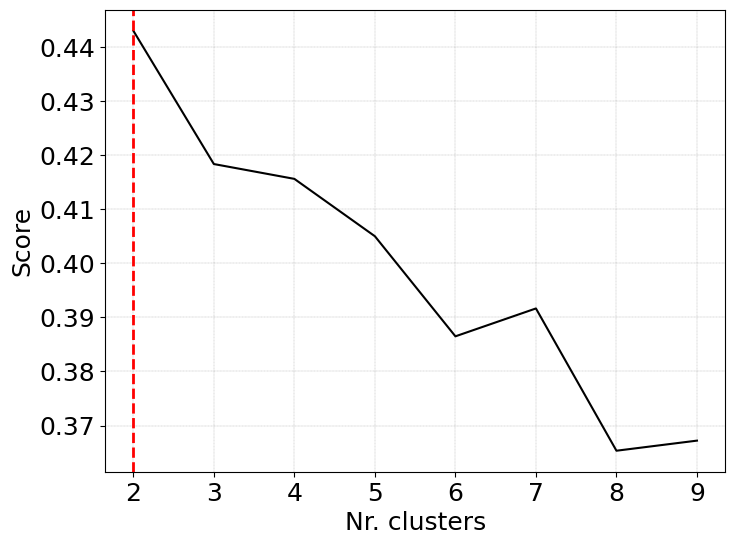

c:\Users\nazar\anaconda3\envs\stability\lib\site-packages\umap\umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


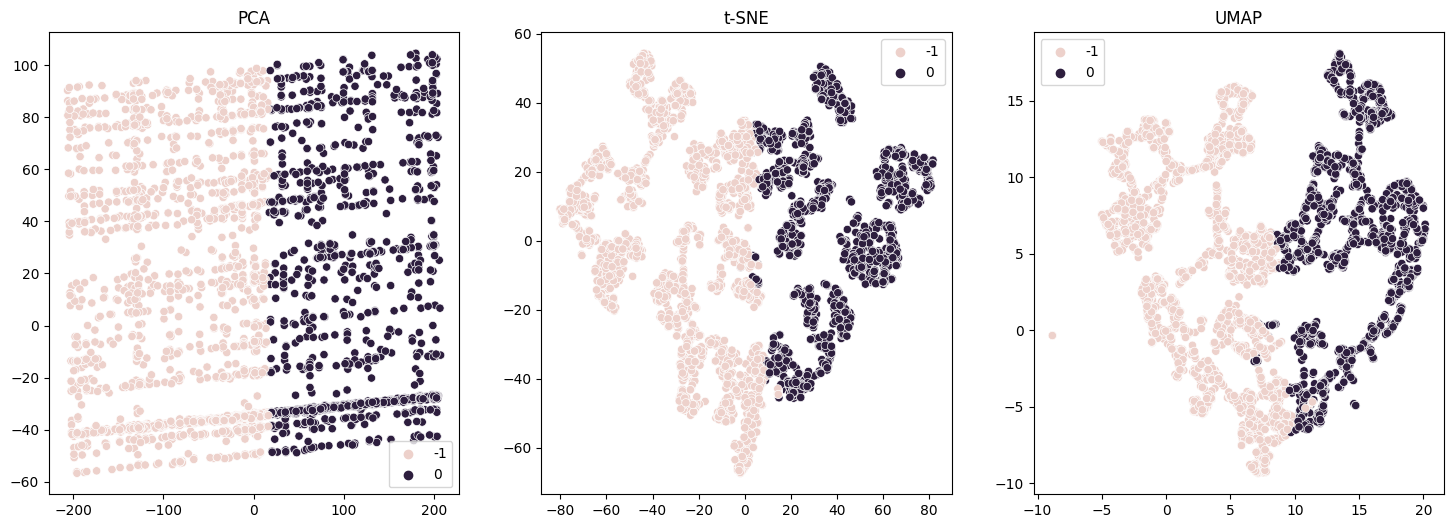

In [56]:
# get dataset ACSIncome
X_train_encoded_acs, cat_encoders_acs, categorical_columns_idxs_acs = get_dataset('acsincome')
best_n_clusters_acs, cluster_labels_acs = silhoeutte_score_experiment(X_train_encoded_acs)
dimesionality_reduction_visualization(X_train_encoded_acs, cluster_labels_acs)

In [10]:
def plot_clustered_data(X, cluster_labels, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[:, 0], X[:, 1], c=cluster_labels, cmap='viridis', s=50, alpha=0.7)
    plt.title(title if title is not None else 'Clustered')
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.colorbar(label='Cluster')
    plt.grid(True)
    plt.show()